In [1]:
import openmc
import openmc.deplete

%matplotlib inline
import numpy as np

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.4)

clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);

water = openmc.Material(name='water');
water.add_element('O',1);
water.add_element('H',2)
water.set_density('g/cc',0.712); # high temperature density
water.add_s_alpha_beta('c_H_in_H2O');

grph = openmc.Material(name='grph');
grph.add_element('C',0.999999);
grph.add_element('B',0.000001);
grph.set_density('g/cc',1.7);
grph.add_s_alpha_beta('c_Graphite');

materials = openmc.Materials([fuel,clad,water,grph]);

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.42;
r_pin = 0.45;

P_D = 1.4;

pitch = P_D*2*r_pin;

fuel_temp = 900; # K, guess at fuel temperature
mod_temp = 600; # K, moderator temperature

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & -core_cell;
mod_cell.fill = grph

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();



In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 10000;
settings.batches = 100;
settings.inactive = 25

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

#settings.temperature['method']='interpolation';

settings.export_to_xml();

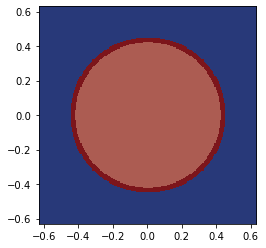

In [5]:
root_univ.plot(width=(pitch,pitch));

In [6]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

note for cold begining of life, $k_{\text{eff}} = 1.45998 \pm 0.00154$.

for hot beginning of life, $k_{\text{eff}} = 1.37613 \pm 0.00153$.

In [7]:
#operator = openmc.deplete.Operator(geometry,settings,"chain_casl_pwr.xml");
operator = openmc.deplete.Operator(geometry,settings,"chain_endfb71_pwr.xml");


power = 1e4;
days = 24*3600;
time_steps = [0.1*days,0.1*days,0.3*days,0.5*days,1.*days,30.*days,30.*days,100.*days, 360.*days, 360.*days, 360.*days,360.*days,720.*days,720.*days];
integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);

In [8]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading S32 from /home/sblair/OMC_DATA/endfb71_hdf5/S32.h5
 Reading S33 from /home/sblair/OMC_DATA/endfb71_hdf5/S33.h5
 Reading S34 from /home/sblair/OMC_DATA/endfb71_hdf5/S34.h5
 Reading S36 from /home/sblair/OMC_DATA/endfb71_hdf5/S36.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5


 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/sblair/OMC_DATA/endfb71_hdf5/K39.h5
 Reading K40 from /home/sblair/OMC_DATA/endfb71_hdf5/K40.h5
 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5
 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 

 Reading Se82 from /home/sblair/OMC_DATA/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/sblair/OMC_DATA/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading Sr87 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr87.h5
 Reading

 Reading Mo92 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo92.h5
 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5


 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endf

          1200K
          2500K


 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn117.h5
 Reading Sn118 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn118.h5
 Reading Sn119 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn119.h5
 Reading Sn120 from /home/sblair/O

          1200K
          2500K


 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5


          1200K
          2500K


 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5
 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5


          1200K


 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.71803
        2/1    0.74533
        3/1    0.76956
        4/1    0.78617
        5/1    0.78765
        6/1    0.80274
        7/1    0.79688
        8/1    0.81018
        9/1    0.81204
       10/1    0.81778
       11/1    0.82026
       12/1    0.81552
       13/1    0.83209
       14/1    0.83277
       15/1    0.84296
       16/1    0.86340
       17/1    0.83159
       18/1    0.83839
       19/1    0.86483
       20/1    0.84816
       21/1    0.83948
       22/1    0.85381
       23/1    0.83299
       24/1    0.85656
       25/1    0.86723
       26/1    0.84757
       27/1    0.85935    0.85346 +/- 0.00589
       28/1    0.86884    0.85859 +/- 0.00615
       29/1    0.84728    0.85576 +/- 0.00519
       30/1    0.86248    0.85710 +/- 0.00424
       31/1    0.85

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.72785
        2/1    0.74537
        3/1    0.76234
        4/1    0.77291
        5/1    0.78533
        6/1    0.79890
        7/1    0.82935
        8/1    0.80696
        9/1    0.83715
       10/1    0.81580
       11/1    0.84252
       12/1    0.84076
       13/1    0.83160
       14/1    0.83953
       15/1    0.84267
       16/1    0.83766
       17/1    0.83580
       18/1    0.85258
       19/1    0.85711
       20/1    0.84890
       21/1    0.86331
       22/1    0.84037
       23/1    0.85025
       24/1    0.85708
       25/1    0.86010
       26/1    0.84299
       27/1    0.85805    0.85052 +/- 0.00753
       28/1    0.84154    0.84753 +/- 0.00528
       29/1    0.83351    0.84402 +/- 0.00512
       30/1    0.85558    0.84633 +/- 0.00459
       31/1    0.83

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.73364
        2/1    0.73667
        3/1    0.75429
        4/1    0.78610
        5/1    0.78179
        6/1    0.80549
        7/1    0.81111
        8/1    0.81265
        9/1    0.83946
       10/1    0.83796
       11/1    0.83346
       12/1    0.82778
       13/1    0.83773
       14/1    0.85345
       15/1    0.84818
       16/1    0.85973
       17/1    0.84629
       18/1    0.83696
       19/1    0.86348
       20/1    0.86246
       21/1    0.86006
       22/1    0.84757
       23/1    0.84385
       24/1    0.85355
       25/1    0.85904
       26/1    0.84231
       27/1    0.86145    0.85188 +/- 0.00957
       28/1    0.85178    0.85185 +/- 0.00552
       29/1    0.84445    0.85000 +/- 0.00432
       30/1    0.85069    0.85014 +/- 0.00335
       31/1    0.87

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.73096
        2/1    0.73636
        3/1    0.75218
        4/1    0.78196
        5/1    0.78270
        6/1    0.79209
        7/1    0.80674
        8/1    0.79718
        9/1    0.82928
       10/1    0.81335
       11/1    0.82230
       12/1    0.82145
       13/1    0.84005
       14/1    0.83482
       15/1    0.86812
       16/1    0.85570
       17/1    0.83737
       18/1    0.82564
       19/1    0.84677
       20/1    0.83004
       21/1    0.84941
       22/1    0.84886
       23/1    0.86014
       24/1    0.83622
       25/1    0.85775
       26/1    0.86348
       27/1    0.85232    0.85790 +/- 0.00558
       28/1    0.85584    0.85721 +/- 0.00329
       29/1    0.86523    0.85922 +/- 0.00307
       30/1    0.84710    0.85680 +/- 0.00340
       31/1    0.85

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.73276
        2/1    0.74841
        3/1    0.75453
        4/1    0.76414
        5/1    0.78552
        6/1    0.79368
        7/1    0.81065
        8/1    0.81120
        9/1    0.80555
       10/1    0.82853
       11/1    0.83053
       12/1    0.79940
       13/1    0.83443
       14/1    0.86507
       15/1    0.81563
       16/1    0.83613
       17/1    0.83990
       18/1    0.82411
       19/1    0.85016
       20/1    0.82481
       21/1    0.86783
       22/1    0.83168
       23/1    0.84479
       24/1    0.83947
       25/1    0.84015
       26/1    0.83446
       27/1    0.85543    0.84495 +/- 0.01048
       28/1    0.81611    0.83533 +/- 0.01136
       29/1    0.83203    0.83451 +/- 0.00807
       30/1    0.82134    0.83187 +/- 0.00679
       31/1    0.82

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.72059
        2/1    0.74161
        3/1    0.75324
        4/1    0.76251
        5/1    0.78850
        6/1    0.79420
        7/1    0.78736
        8/1    0.79770
        9/1    0.80335
       10/1    0.81517
       11/1    0.80439
       12/1    0.81630
       13/1    0.83774
       14/1    0.85365
       15/1    0.82174
       16/1    0.84203
       17/1    0.83462
       18/1    0.85524
       19/1    0.84554
       20/1    0.85032
       21/1    0.84165
       22/1    0.83428
       23/1    0.83694
       24/1    0.83398
       25/1    0.84503
       26/1    0.83281
       27/1    0.84926    0.84104 +/- 0.00822
       28/1    0.84152    0.84120 +/- 0.00475
       29/1    0.85521    0.84470 +/- 0.00485
       30/1    0.83063    0.84189 +/- 0.00470
       31/1    0.84

 Maximum neutron transport energy: 8100000.0 eV for Be7
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.72429
        2/1    0.73187
        3/1    0.74512
        4/1    0.76277
        5/1    0.79124
        6/1    0.76740
        7/1    0.81151
        8/1    0.79522
        9/1    0.80457
       10/1    0.82481
       11/1    0.81839
       12/1    0.81844
       13/1    0.82811
       14/1    0.81564
       15/1    0.82219
       16/1    0.83344
       17/1    0.82938
       18/1    0.84280
       19/1    0.83305
       20/1    0.83789
       21/1    0.83256
       22/1    0.82124
       23/1    0.84839
       24/1    0.82253
       25/1    0.82543
       26/1    0.83365
       27/1    0.84099    0.83732 +/- 0.00367
       28/1    0.82794    0.83419 +/- 0.00377
       29/1    0.82424    0.83170 +/- 0.00365
       30

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.71381
        2/1    0.76198
        3/1    0.74375
        4/1    0.75874
        5/1    0.77318
        6/1    0.78912
        7/1    0.78539
        8/1    0.79923
        9/1    0.79872
       10/1    0.80922
       11/1    0.83075
       12/1    0.83235
       13/1    0.81825
       14/1    0.83477
       15/1    0.82443
       16/1    0.82800
       17/1    0.82814
       18/1    0.83261
       19/1    0.83846
       20/1    0.83451
       21/1    0.83934
       22/1    0.82376
       23/1    0.84933
       24/1    0.83152
       25/1    0.84421
       26/1    0.82710
       27/1    0.84295    0.83503 +/- 0.00793
       28/1    0.82804    0.83270 +/- 0.00514
       29/1    0.83335    0.83286 +/- 0.00364
       30/1    0.82788    0.83186 +/- 0.00299
       31/1    0.84

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.73327
        2/1    0.74371
        3/1    0.74985
        4/1    0.76122
        5/1    0.77314
        6/1    0.79178
        7/1    0.78242
        8/1    0.79892
        9/1    0.79930
       10/1    0.82361
       11/1    0.80859
       12/1    0.82292
       13/1    0.81173
       14/1    0.81728
       15/1    0.82972
       16/1    0.82907
       17/1    0.80856
       18/1    0.84354
       19/1    0.82679
       20/1    0.83605
       21/1    0.84988
       22/1    0.81645
       23/1    0.84302
       24/1    0.82845
       25/1    0.82968
       26/1    0.83244
       27/1    0.81479    0.82361 +/- 0.00882
       28/1    0.82008    0.82243 +/- 0.00523
       29/1    0.82071    0.82200 +/- 0.00372
       30/1    0.83476    0.82455 +/- 0.00385
       31/1    0.82

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.73271
        2/1    0.73778
        3/1    0.75526
        4/1    0.75906
        5/1    0.76545
        6/1    0.77847
        7/1    0.79508
        8/1    0.76821
        9/1    0.78798
       10/1    0.81544
       11/1    0.82567
       12/1    0.80947
       13/1    0.81544
       14/1    0.79500
       15/1    0.81701
       16/1    0.83417
       17/1    0.81758
       18/1    0.82303
       19/1    0.82036
       20/1    0.82261
       21/1    0.83271
       22/1    0.83330
       23/1    0.80999
       24/1    0.81837
       25/1    0.83117
       26/1    0.81522
       27/1    0.82503    0.82013 +/- 0.00491
       28/1    0.81658    0.81895 +/- 0.00307
       29/1    0.84380    0.82516 +/- 0.00658
       30/1    0.84566    0.82926 +/- 0.00654
       31/1    0.83

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.73695
        2/1    0.74877
        3/1    0.76093
        4/1    0.75911
        5/1    0.78332
        6/1    0.79487
        7/1    0.79113
        8/1    0.78506
        9/1    0.78918
       10/1    0.80039
       11/1    0.80319
       12/1    0.78834
       13/1    0.81398
       14/1    0.81631
       15/1    0.80189
       16/1    0.82571
       17/1    0.81322
       18/1    0.81061
       19/1    0.81532
       20/1    0.82126
       21/1    0.81954
       22/1    0.81912
       23/1    0.82263
       24/1    0.84624
       25/1    0.82524
       26/1    0.82615
       27/1    0.84998    0.83807 +/- 0.01191
       28/1    0.80457    0.82690 +/- 0.01311
       29/1    0.83100    0.82793 +/- 0.00933
       30/1    0.83239    0.82882 +/- 0.00728
       31/1    0.83

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.73151
        2/1    0.75472
        3/1    0.75418
        4/1    0.78310
        5/1    0.76920
        6/1    0.78065
        7/1    0.79552
        8/1    0.79025
        9/1    0.81032
       10/1    0.80685
       11/1    0.79761
       12/1    0.81168
       13/1    0.82653
       14/1    0.81118
       15/1    0.80842
       16/1    0.81369
       17/1    0.80644
       18/1    0.80250
       19/1    0.79910
       20/1    0.80855
       21/1    0.82243
       22/1    0.81352
       23/1    0.81645
       24/1    0.82252
       25/1    0.81686
       26/1    0.80459
       27/1    0.82431    0.81445 +/- 0.00986
       28/1    0.83735    0.82209 +/- 0.00952
       29/1    0.83253    0.82470 +/- 0.00722
       30/1    0.83938    0.82763 +/- 0.00632
       31/1    0.83

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.74945
        2/1    0.75965
        3/1    0.74853
        4/1    0.77092
        5/1    0.77632
        6/1    0.79298
        7/1    0.78720
        8/1    0.80312
        9/1    0.79749
       10/1    0.80252
       11/1    0.81538
       12/1    0.80335
       13/1    0.82165
       14/1    0.81890
       15/1    0.82982
       16/1    0.80287
       17/1    0.81453
       18/1    0.82314
       19/1    0.82763
       20/1    0.83036
       21/1    0.83184
       22/1    0.83120
       23/1    0.83172
       24/1    0.82593
       25/1    0.81756
       26/1    0.83088
       27/1    0.83435    0.83261 +/- 0.00173
       28/1    0.81079    0.82534 +/- 0.00734
       29/1    0.84660    0.83065 +/- 0.00743
       30/1    0.82116    0.82875 +/- 0.00606
       31/1    0.80

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.72448
        2/1    0.76331
        3/1    0.78190
        4/1    0.76977
        5/1    0.79992
        6/1    0.79163
        7/1    0.79270
        8/1    0.81099
        9/1    0.81454
       10/1    0.79667
       11/1    0.81080
       12/1    0.81081
       13/1    0.80773
       14/1    0.81179
       15/1    0.82466
       16/1    0.83145
       17/1    0.81937
       18/1    0.81641
       19/1    0.80624
       20/1    0.84760
       21/1    0.82076
       22/1    0.82471
       23/1    0.80470
       24/1    0.82281
       25/1    0.81087
       26/1    0.84127
       27/1    0.81824    0.82976 +/- 0.01152
       28/1    0.83460    0.83137 +/- 0.00684
       29/1    0.81581    0.82748 +/- 0.00621
       30/1    0.84236    0.83046 +/- 0.00566
       31/1    0.83

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.75096
        2/1    0.75288
        3/1    0.77340
        4/1    0.77962
        5/1    0.78545
        6/1    0.78650
        7/1    0.79942
        8/1    0.81265
        9/1    0.79914
       10/1    0.80731
       11/1    0.81002
       12/1    0.82927
       13/1    0.81322
       14/1    0.82260
       15/1    0.81454
       16/1    0.82076
       17/1    0.82216
       18/1    0.81745
       19/1    0.81042
       20/1    0.82704
       21/1    0.83678
       22/1    0.82077
       23/1    0.82770
       24/1    0.81862
       25/1    0.82396
       26/1    0.82510
       27/1    0.82490    0.82500 +/- 0.00010
       28/1    0.82930    0.82643 +/- 0.00143
       29/1    0.83662    0.82898 +/- 0.00274
       30/1    0.81314    0.82581 +/- 0.00381
       31/1    0.81

In [9]:
results = openmc.deplete.ResultsList.from_hdf5('./depletion_results.h5')

In [10]:
time,k = results.get_eigenvalue()
time /= (24*60*60);

In [11]:
from matplotlib import pyplot

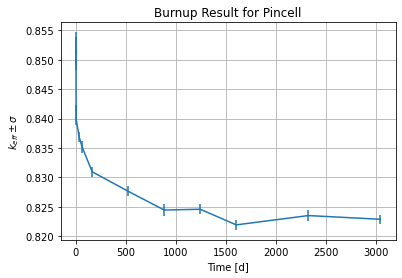

In [12]:
pyplot.errorbar(time,k[:,0],yerr=k[:,1]);
pyplot.title('Burnup Result for Pincell')
pyplot.xlabel('Time [d]');
pyplot.ylabel('$k_{eff} \pm \sigma$');
pyplot.grid()

In [13]:
chain = openmc.deplete.Chain.from_xml("chain_endfb71_pwr.xml")

In [14]:
chain.nuclide_dict

OrderedDict([('H1', 0),
             ('H2', 1),
             ('H3', 2),
             ('H4', 3),
             ('H5', 4),
             ('H6', 5),
             ('H7', 6),
             ('He3', 7),
             ('He4', 8),
             ('He5', 9),
             ('He6', 10),
             ('He7', 11),
             ('He8', 12),
             ('He9', 13),
             ('He10', 14),
             ('Li4', 15),
             ('Li5', 16),
             ('Li6', 17),
             ('Li7', 18),
             ('Li8', 19),
             ('Li9', 20),
             ('Li10', 21),
             ('Li11', 22),
             ('Li12', 23),
             ('Be5', 24),
             ('Be6', 25),
             ('Be7', 26),
             ('Be8', 27),
             ('Be9', 28),
             ('Be10', 29),
             ('Be11', 30),
             ('Be12', 31),
             ('Be13', 32),
             ('Be14', 33),
             ('Be15', 34),
             ('Be16', 35),
             ('B6', 36),
             ('B7', 37),
             ('B8', 

In [15]:
time, xe135 = results.get_atoms("1","Xe135")

Text(0, 0.5, 'Number of atoms - Xe135')

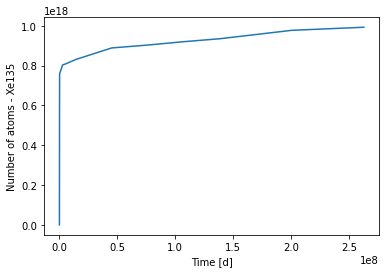

In [16]:
pyplot.plot(time,xe135,label="Xe135")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe135")

In [17]:
time, cs137 = results.get_atoms("1","Cs137")

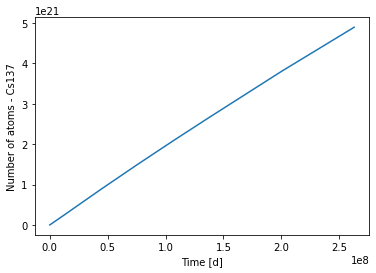

In [18]:
pyplot.plot(time,cs137,label="Cs137");
pyplot.xlabel("Time [d]");
pyplot.ylabel("Number of atoms - Cs137");